In [1]:
!pip install librosa
!pip install torch
!pip install torchaudio
!pip install matplotlib
!pip install numpy
!pip install tqdm
!pip install tensorboard

In [2]:
import os
import random
import numpy as np
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

# Helper functions
def list_files(dataset_path):
    files = []
    for root, dirs, filenames in os.walk(dataset_path):
        for filename in filenames:
            if filename.endswith(".wav"):
                files.append(os.path.join(root, filename))
    return files

def parse_filename(filename):
    parts = filename.split('-')
    emotion = int(parts[2]) - 1  # 0-based emotion
    return {
        'modality': int(parts[0]),
        'vocal_channel': int(parts[1]),
        'emotion': emotion,  
        'intensity': int(parts[3]),
        'statement': int(parts[4]),
        'repetition': int(parts[5]),
        'actor': int(parts[6].split('.')[0])
    }

def preprocess_audio(signal, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

class MelSpectrogramTransform:
    def __call__(self, signal):
        return preprocess_audio(signal)

class AugmentedMelSpectrogramTransform:
    def __call__(self, signal):
        signal = preprocess_audio(signal)
        
        # Random time shift
        if random.random() > 0.5:
            signal = np.roll(signal, shift=random.randint(-5, 5), axis=1)
        
        # Random noise
        if random.random() > 0.5:
            noise = np.random.randn(*signal.shape) * 0.01
            signal = signal + noise
        
        return signal


In [3]:
class RAVDESSDataset(Dataset):
    def __init__(self, file_list, transform=None, max_len=200):
        self.file_list = file_list
        self.transform = transform
        self.max_len = max_len

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        label = parse_filename(os.path.basename(file_path))['emotion']
        
        signal, sr = librosa.load(file_path, sr=22050)
        
        if self.transform:
            signal = self.transform(signal)
        
        if signal.shape[1] < self.max_len:
            pad_width = self.max_len - signal.shape[1]
            signal = np.pad(signal, ((0, 0), (0, pad_width)), mode='constant')
        else:
            signal = signal[:, :self.max_len]
        
        return signal, label

def collate_fn(batch):
    signals, labels = zip(*batch)
    
    max_len = max(signal.shape[1] for signal in signals)
    
    padded_signals = []
    for signal in signals:
        pad_width = max_len - signal.shape[1]
        padded_signal = np.pad(signal, ((0, 0), (0, pad_width)), mode='constant')
        padded_signals.append(padded_signal)
    
    signals_array = np.array(padded_signals)
    
    signals_tensor = torch.tensor(signals_array)
    labels_tensor = torch.tensor(labels)
    
    return signals_tensor, labels_tensor

DATASET_PATH = "/Users/yamini/Desktop/RAVDESS Dataset"
files = list_files(DATASET_PATH)
train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

train_dataset = RAVDESSDataset(train_files, transform=AugmentedMelSpectrogramTransform())
test_dataset = RAVDESSDataset(test_files, transform=MelSpectrogramTransform())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [4]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        # Placeholder value for the input size to the first fully connected layer
        self.fc_input_size = 32 * 32 * 45  # This will be recalculated dynamically
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, 8)  # 8 emotions

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(x.size(0), -1)  
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _get_fc_input_size(self, shape):
        x = torch.rand(shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x.view(x.size(0), -1).size(1)

model = EmotionCNN()

dummy_input = (1, 1, 128, 200)  # (batch_size, channels, height, width)
model.fc_input_size = model._get_fc_input_size(dummy_input)

model.fc1 = nn.Linear(model.fc_input_size, 128)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def evaluate(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for signals, labels in test_loader:
            signals = signals.unsqueeze(1).float()  
            labels = labels.long()
            outputs = model(signals.float())  
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    average_loss = running_loss / len(test_loader)
    return accuracy, average_loss

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, patience=3):
    writer = SummaryWriter() 
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    test_losses = []
    best_test_accuracy = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (signals, labels) in progress_bar:
            signals = signals.unsqueeze(1).float() 
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(signals.float()) 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(loss=running_loss / (i + 1), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        test_accuracy, test_loss = evaluate(model, test_loader, criterion)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}, Loss: {train_loss}, Train Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%, Test Loss: {test_loss}")

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/test', test_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/test', test_accuracy, epoch)

        # Early stopping
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    writer.close()
    return train_losses, train_accuracies, test_accuracies, test_losses

train_losses, train_accuracies, test_accuracies, test_losses = train(model, train_loader, test_loader, criterion, optimizer, num_epochs=20, patience=5)

Epoch 1/20: 100%|██████████| 36/36 [00:23<00:00,  1.51it/s, accuracy=16.6, loss=20.3]


Epoch 1, Loss: 20.298580716053646, Train Accuracy: 16.57986111111111%, Test Accuracy: 17.01388888888889%, Test Loss: 2.037488659222921


Epoch 2/20: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s, accuracy=19.8, loss=2.01]


Epoch 2, Loss: 2.0103587408860526, Train Accuracy: 19.791666666666668%, Test Accuracy: 22.569444444444443%, Test Loss: 1.9580413500467937


Epoch 3/20: 100%|██████████| 36/36 [00:22<00:00,  1.63it/s, accuracy=26.1, loss=1.93]


Epoch 3, Loss: 1.929817732837465, Train Accuracy: 26.12847222222222%, Test Accuracy: 26.041666666666668%, Test Loss: 1.871175315645006


Epoch 4/20: 100%|██████████| 36/36 [00:22<00:00,  1.62it/s, accuracy=28.7, loss=1.82]


Epoch 4, Loss: 1.8219381637043424, Train Accuracy: 28.73263888888889%, Test Accuracy: 29.166666666666668%, Test Loss: 1.8555386596255832


Epoch 5/20: 100%|██████████| 36/36 [00:22<00:00,  1.62it/s, accuracy=37.1, loss=1.71]


Epoch 5, Loss: 1.7087168991565704, Train Accuracy: 37.06597222222222%, Test Accuracy: 34.72222222222222%, Test Loss: 1.7836908896764119


Epoch 6/20: 100%|██████████| 36/36 [00:26<00:00,  1.37it/s, accuracy=39.8, loss=1.58]


Epoch 6, Loss: 1.5769667393631406, Train Accuracy: 39.84375%, Test Accuracy: 37.15277777777778%, Test Loss: 1.6431416140662298


Epoch 7/20: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s, accuracy=49.1, loss=1.43]


Epoch 7, Loss: 1.4318016866842906, Train Accuracy: 49.13194444444444%, Test Accuracy: 41.666666666666664%, Test Loss: 1.649079852634006


Epoch 8/20: 100%|██████████| 36/36 [00:22<00:00,  1.61it/s, accuracy=51.2, loss=1.34]


Epoch 8, Loss: 1.3368320299519434, Train Accuracy: 51.21527777777778%, Test Accuracy: 41.31944444444444%, Test Loss: 1.5841015312406752


Epoch 9/20: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s, accuracy=54.3, loss=1.26]


Epoch 9, Loss: 1.2591962698433135, Train Accuracy: 54.34027777777778%, Test Accuracy: 47.22222222222222%, Test Loss: 1.526467416021559


Epoch 10/20: 100%|██████████| 36/36 [00:22<00:00,  1.57it/s, accuracy=57.4, loss=1.16]


Epoch 10, Loss: 1.1580837650431528, Train Accuracy: 57.37847222222222%, Test Accuracy: 47.22222222222222%, Test Loss: 1.4705270263883803


Epoch 11/20: 100%|██████████| 36/36 [00:22<00:00,  1.61it/s, accuracy=60.2, loss=1.09]


Epoch 11, Loss: 1.091469527946578, Train Accuracy: 60.15625%, Test Accuracy: 48.958333333333336%, Test Loss: 1.4374260902404785


Epoch 12/20: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s, accuracy=62.8, loss=1.01] 


Epoch 12, Loss: 1.0122155762381024, Train Accuracy: 62.760416666666664%, Test Accuracy: 51.041666666666664%, Test Loss: 1.4041551351547241


Epoch 13/20: 100%|██████████| 36/36 [00:24<00:00,  1.49it/s, accuracy=67.9, loss=0.916]


Epoch 13, Loss: 0.9157956838607788, Train Accuracy: 67.88194444444444%, Test Accuracy: 50.34722222222222%, Test Loss: 1.4298485385047064


Epoch 14/20: 100%|██████████| 36/36 [00:24<00:00,  1.45it/s, accuracy=68.5, loss=0.89] 


Epoch 14, Loss: 0.8900407337480121, Train Accuracy: 68.48958333333333%, Test Accuracy: 51.736111111111114%, Test Loss: 1.463000668419732


Epoch 15/20: 100%|██████████| 36/36 [00:25<00:00,  1.41it/s, accuracy=70.7, loss=0.84] 


Epoch 15, Loss: 0.8399834450748231, Train Accuracy: 70.65972222222223%, Test Accuracy: 50.0%, Test Loss: 1.4449123806423612


Epoch 16/20: 100%|██████████| 36/36 [00:25<00:00,  1.41it/s, accuracy=70.8, loss=0.828]


Epoch 16, Loss: 0.8283135112788942, Train Accuracy: 70.83333333333333%, Test Accuracy: 46.52777777777778%, Test Loss: 1.4118742810355291


Epoch 17/20: 100%|██████████| 36/36 [00:24<00:00,  1.46it/s, accuracy=72.9, loss=0.765]


Epoch 17, Loss: 0.7650020437108146, Train Accuracy: 72.91666666666667%, Test Accuracy: 49.65277777777778%, Test Loss: 1.34870183467865


Epoch 18/20: 100%|██████████| 36/36 [00:23<00:00,  1.52it/s, accuracy=76.2, loss=0.708]


Epoch 18, Loss: 0.708487277229627, Train Accuracy: 76.21527777777777%, Test Accuracy: 53.125%, Test Loss: 1.3963413503434923


Epoch 19/20: 100%|██████████| 36/36 [00:23<00:00,  1.56it/s, accuracy=76.2, loss=0.665]


Epoch 19, Loss: 0.6648900417817963, Train Accuracy: 76.21527777777777%, Test Accuracy: 49.65277777777778%, Test Loss: 1.4765086306465998


Epoch 20/20: 100%|██████████| 36/36 [00:22<00:00,  1.61it/s, accuracy=76.5, loss=0.659]


Epoch 20, Loss: 0.6591894866691695, Train Accuracy: 76.47569444444444%, Test Accuracy: 51.388888888888886%, Test Loss: 1.4276693794462416


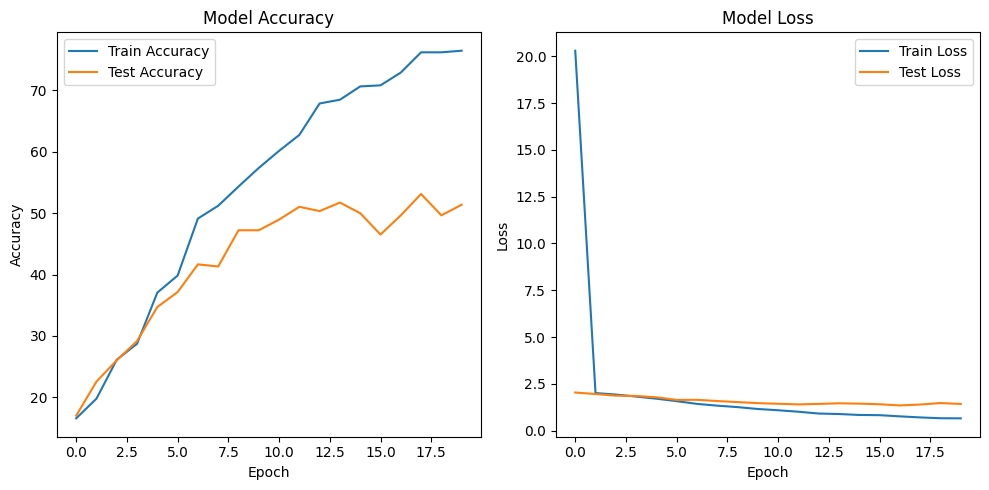

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [7]:
# Save the model
model_save_path = "Desktop/emotion_cnn_model.pth"
torch.save(model.state_dict(), model_save_path)